# Evaluation of Graph Neural Network segment classifier

In [1]:
# Concurrency config
import os
os.environ['OMP_NUM_THREADS'] = '4'

In [2]:
import yaml

import numpy as np
import sklearn.metrics

import torch
from torch.utils.data import Subset, DataLoader

import matplotlib.pyplot as plt

In [3]:
# Local software setup
import sys
sys.path.append('..')

from models import get_model
from datasets.hitgraphs import HitGraphDataset, collate_fn

In [4]:
%matplotlib inline

In [5]:
def get_output_dir(config):
    return os.path.expandvars(config['experiment']['output_dir'])

def get_input_dir(config):
    return os.path.expandvars(config['data']['input_dir'])

def load_config(config_file):
    with open(config_file) as f:
        return yaml.load(f)

def load_summaries(config):
    summary_file = os.path.join(get_output_dir(config), 'summaries.npz')
    return np.load(summary_file)

def load_model(config, reload_epoch):
    print('loading model')
    model_config = config['model']
    model_type = model_config.pop('model_type')
    model_config.pop('optimizer', None)
    model_config.pop('learning_rate', None)
    model_config.pop('loss_func', None)
    model = get_model(name=model_type, **model_config)
    
    # Reload specified model checkpoint
    output_dir = get_output_dir(config)
    checkpoint_file = os.path.join(output_dir, 'checkpoints',
                                   'model_checkpoint_%03i.pth.tar' % reload_epoch)
    model.load_state_dict(torch.load(checkpoint_file, map_location='cpu')['model'])
    return model

In [15]:
# Concurrency config
os.environ['OMP_NUM_THREADS'] = '4'

# Config path
config_file = '../configs/hello_graph.yaml'

In [16]:
!cat $config_file

data:
    name: hitgraphs
    n_train: 1000
    n_valid: 500
    batch_size: 2
    input_dir: /global/cscratch1/sd/xju/heptrkx/data/hitgraphs_001

experiment:
    name: gnn
    output_dir: test_run_001

train:
    n_epochs: 20

model:
    model_type: 'gnn_segment_classifier'
    input_dim: 3
    n_iters: 6
    hidden_dim: 128
    loss_func: 'binary_cross_entropy'
    optimizer: 'Adam'
    learning_rate: 0.001


In [25]:
config = load_config(config_file)
summaries = load_summaries(config)

## Plot the Training loss and accuracy

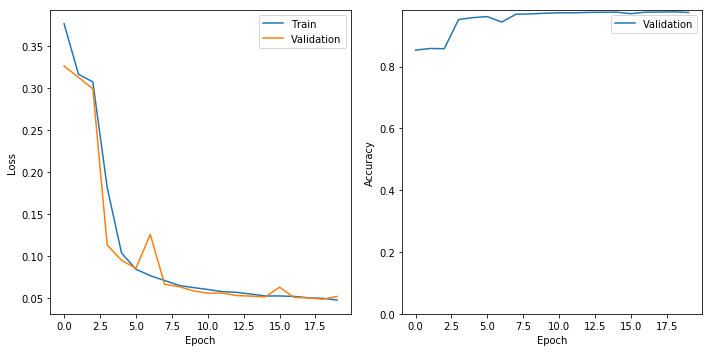

In [26]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))

ax0.plot(summaries['epoch'], summaries['train_loss'], label='Train')
ax0.plot(summaries['epoch'], summaries['valid_loss'], label='Validation')
ax0.set_xlabel('Epoch', )
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

ax1.plot(summaries['epoch'], summaries['valid_acc'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(bottom=0, )
ax1.legend(loc=0)

plt.tight_layout()

## Load the trained model

In [27]:
model = load_model(config, reload_epoch=18).eval()

loading model


## Load the test data set

In [29]:
n_test = 10

In [30]:
full_dataset = HitGraphDataset(get_input_dir(config))

# Take the test set from the back
test_indices = len(full_dataset) - 1 - torch.arange(n_test)
test_dataset = Subset(full_dataset, test_indices)

In [31]:
# Construct a data loaer
test_loader = DataLoader(test_dataset, collate_fn=collate_fn)

## Evaluate the model on the test dataset

In [32]:
%%time

with torch.no_grad():
    test_outputs = [(model(batch_input).flatten(), batch_target.flatten())
                    for (batch_input, batch_target) in test_loader]
    test_pred, test_target = zip(*test_outputs)
    test_pred = np.concatenate(test_pred)
    test_target = np.concatenate(test_target)

CPU times: user 22.8 s, sys: 538 ms, total: 23.4 s
Wall time: 6.04 s


In [33]:
thresh = 0.5
y_pred, y_true = (test_pred > thresh), (test_target > thresh)
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(y_true, y_pred))
print('Precision: %.4f' % sklearn.metrics.precision_score(y_true, y_pred))
print('Recall:    %.4f' % sklearn.metrics.recall_score(y_true, y_pred))

Test set results with threshold of 0.5
Accuracy:  0.9722
Precision: 0.9443
Recall:    0.9484


In [34]:
# ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, test_pred)

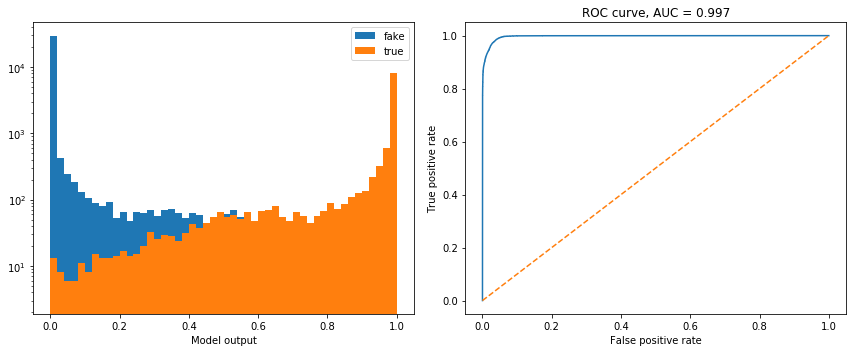

In [35]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the model outputs
binning=dict(bins=50, range=(0,1), histtype='bar', log=True)
ax0.hist(test_pred[y_true==False], label='fake', **binning)
ax0.hist(test_pred[y_true], label='true', **binning)
ax0.set_xlabel('Model output')
ax0.legend(loc=0)

# Plot the ROC curve
auc = sklearn.metrics.auc(fpr, tpr)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], '--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve, AUC = %.3f' % auc)

plt.tight_layout()

## Visualize predictions

In [36]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=True, figsize=(15, 7)):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    ax0.set_xlabel('$z$')
    ax1.set_xlabel('$\phi$')
    ax0.set_ylabel('$r$')
    ax1.set_ylabel('$r$')
    plt.tight_layout()

CPU times: user 20.5 s, sys: 162 ms, total: 20.6 s
Wall time: 20.6 s


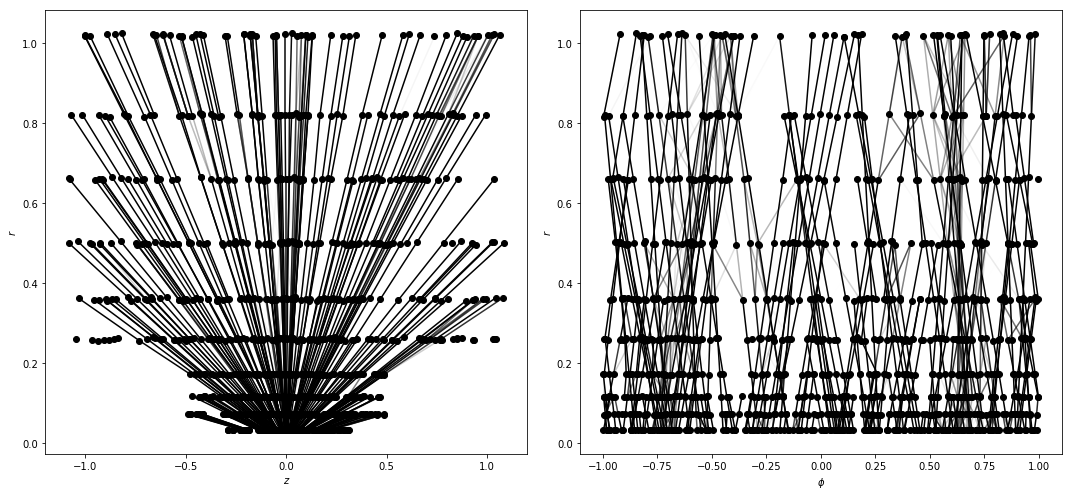

In [37]:
%%time

n_draw = 1
for i in range(n_draw):
    X, Ri, Ro, y = test_dataset[i]
    pred = test_outputs[i][0].numpy()
    draw_sample(X, Ri, Ro, pred, alpha_labels=True)

## Focus on one $\phi$ section in one event, try to compose a track out of hits and edges

In [38]:
file_name = '/global/cscratch1/sd/xju/heptrkx/data/hitgraphs_001/event000001000_g000.npz'
id_name   = '/global/cscratch1/sd/xju/heptrkx/data/hitgraphs_002/event000001000_g000_ID.npz'

In [39]:
from datasets.graph import load_graph

In [40]:
G = load_graph(file_name)

In [59]:
f = np.load(id_name)

In [65]:
hit_ids = f['ID']
print(hit_ids.shape, G.X.shape, G.Ri.shape)

(1676,) (1676, 3) (1676, 5796)


In [66]:
n_hits = G.X.shape[0]
n_features = G.X.shape[1]
n_edges = G.Ri.shape[1]

In [83]:
batch_input = [torch.from_numpy(m[None]).float() for m in [G.X, G.Ri, G.Ro]]

In [86]:
with torch.no_grad():
    test_outputs = model(batch_input).flatten()

In [67]:
event_input_name = '/global/cscratch1/sd/xju/heptrkx/trackml_inputs/train_all/event000001000'

In [68]:
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

In [69]:
hits, cells, particles, truth = load_event(event_input_name)

In [90]:
idx = 0

hit_id = hit_ids[idx]
hit_features = G.X[0]
hit_out = G.Ro[0]
hit_in  = G.Ri[0]
weights = test_outputs.numpy()

In [111]:
hit_out.nonzero()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),)

In [80]:
print(hit_id, hit_features, hit_out.shape, hit_in.shape, weights.shape)

19428 [ 0.03199581 -0.15061387 -0.0266578 ] (5796,) (5796,) (3736,)


In [105]:
max_weight_idx = np.argsort((hit_out * weights))[-1]
next_hit = G.Ri[:, max_weight_idx].nonzero()
if next_hit.size() > 0:
    next_hit_id = next_hit[0][0]

array([1937,    3,    7,    6,    5,    1,    2,    8,    4,    0])

In [185]:
%%time

hits_in_tracks = []
hits_idx_in_tracks = []
all_tracks = []
all_idx_tracks = []
weights = test_outputs.numpy()
for idx in range(n_hits):
    # Loop over all hits 
    # and save hits that are used in a track
    hit_id = hit_ids[idx]
    if hit_id not in hits_in_tracks:
        hits_in_tracks.append(hit_id)
        hits_idx_in_tracks.append(idx)
    else:
        continue

    a_track = [hit_id]
    a_idx_track = [idx]
    while(True):
        # for this hit index (idx),
        # find its outgoing hits that could form a track
        hit_out = G.Ro[idx]
        if hit_out.nonzero()[0].shape[0] < 1:
            break
        weighted_outgoing = np.argsort((hit_out * weights))
        ii = -1
        has_next_hit = False
        while abs(ii) < 12:
            weight_idx = weighted_outgoing[ii]
            next_hit = G.Ri[:, weight_idx].nonzero()
            if next_hit[0].shape[0] > 0:
                next_hit_id = next_hit[0][0]
                if next_hit_id != idx and next_hit_id not in hits_idx_in_tracks:
#                     print(idx,"has next hit:", next_hit_id,"with weight:", weights[weight_idx], "in index of", ii)
                    hits_in_tracks.append(hit_ids[next_hit_id])
                    hits_idx_in_tracks.append(next_hit_id)
                    a_track       .append(hit_ids[next_hit_id])
                    a_idx_track   .append(next_hit_id)
                    idx = next_hit_id
                    has_next_hit = True
                    break
            ii -= 1

        if not has_next_hit:
            # no more out-going tracks
            break
            
    all_tracks    .append(a_track)
    all_idx_tracks.append(a_idx_track)

CPU times: user 479 ms, sys: 0 ns, total: 479 ms
Wall time: 477 ms


In [186]:
print(len(hits_in_tracks))
print(len(hits_idx_in_tracks))

1676
1676


In [188]:
n_used_hits = sum([len(track) for itrk, track in enumerate(all_idx_tracks)])
print("total used hits:", n_used_hits)

total used hits: 1676


(-1, 1)

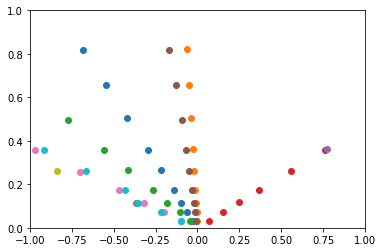

In [190]:
for trk_id in range(10):
    plt.scatter(G.X[all_idx_tracks[trk_id], 2], G.X[all_idx_tracks[trk_id], 0])
plt.ylim(0, 1)
plt.xlim(-1, 1)

In [172]:
idx = 0
while(True):
    # for this hit index (idx),
    # find its outgoing hits that could form a track
    hit_out = G.Ro[idx]
    if hit_out.nonzero()[0].shape[0] < 1:
        break
    weighted_outgoing = np.argsort((hit_out * weights))
    ii = -1
    has_next_hit = False
    while abs(ii) < 12:
        weight_idx = weighted_outgoing[ii]
        next_hit = G.Ri[:, weight_idx].nonzero()
        if next_hit[0].shape[0] > 0:
            next_hit_id = next_hit[0][0]
            if next_hit_id != idx:
                print(idx,"has next hit:", next_hit_id,"with weight:", weights[weight_idx], "in index of", ii)
                idx = next_hit_id
                has_next_hit = True
                break
        ii -= 1

0 has next hit: 1 with weight: 0.9951929 in index of -1
1 has next hit: 2 with weight: 0.99601245 in index of -1
2 has next hit: 3 with weight: 0.9987332 in index of -1
3 has next hit: 4 with weight: 0.9980825 in index of -1
4 has next hit: 5 with weight: 0.996635 in index of -1
5 has next hit: 6 with weight: 0.93261933 in index of -1
6 has next hit: 7 with weight: 0.98705626 in index of -1
7 has next hit: 8 with weight: 0.992424 in index of -1
8 has next hit: 9 with weight: 0.986668 in index of -1


## Build a output for getting a score from track ML.

In [191]:
print(all_tracks[0])

[19428, 28547, 35183, 41395, 73437, 80174, 86640, 92571, 108303, 113314]


In [248]:
print(len(all_tracks))

362


In [192]:
import pandas as pd

In [194]:
print(hits.shape)
hits.head()

(120939, 7)


,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


In [223]:
cuts = hits['hit_id'].map(lambda x: x in [2, 3, 4])
hits[cuts]

/usr/common/software/pytorch/v1.0.0-intel/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,hit_id,x,y,z,volume_id,layer_id,module_id
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1


In [227]:
hits.loc[cuts, 'volume_id'] = 3

In [235]:
df_sub = hits[['hit_id']]
df_sub = df_sub.assign(track_id=0)
df_sub.head()

,hit_id,track_id
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [237]:
%%time 

df_sub = hits[['hit_id']]
df_sub = df_sub.assign(track_id=0)
for itrk, track in enumerate(all_tracks):
    cuts = df_sub['hit_id'].map(lambda x: x in track)
    df_sub.loc[cuts, 'track_id'] = itrk

df_sub.head()

CPU times: user 7min 22s, sys: 19.2 ms, total: 7min 22s
Wall time: 7min 22s


In [239]:
score_event(truth, df_sub)

0.01580016729665637

In [249]:
df_sub2 = hits[['hit_id']]
df_sub2 = df_sub.assign(track_id=0)

In [251]:
results = []
for itrk, track in enumerate(all_tracks):
    results += [(x, itrk) for x in track]

In [256]:
new_df = pd.DataFrame(results, columns=['hit_id', 'track_id'])
new_df[10:20]

,hit_id,track_id
10,19235,1
11,28511,1
12,35815,1
13,42405,1
14,74484,1
15,81487,1
16,88145,1
17,93834,1
18,109844,1
19,115037,1


In [265]:
df_sub3 = df_sub2.copy()
dff = df_sub3.merge(new_df, on='hit_id', how='outer')
dff = dff.fillna(99999)
print(dff.head())
print(dff[dff['hit_id'] == 109844])

   hit_id  track_id_x  track_id_y
0       1           0     99999.0
1       2           0     99999.0
2       3           0     99999.0
3       4           0     99999.0
4       5           0     99999.0
        hit_id  track_id_x  track_id_y
109843  109844           0         1.0


In [246]:
for itrk, track in enumerate(all_tracks):
    cuts = df_sub['hit_id'].map(lambda x: x in track)
    df_sub.loc[cuts, 'track_id'] = itrk

df_sub.head()

[1, 2, 3, 4, 3, 4, 5, 6]


In [247]:
c += a
print(c)

[1, 2, 3, 4, 3, 4, 5, 6, 1, 2, 3, 4]


### Evalation of first event results
  * total tracks:  1374
  * mean score: 0.06420239314690485